# PyTorch - homework TF 3: generative convolutional models

-- Prof. Dorien Herremans

Please run the whole notebook with your code and submit the `.ipynb` file on eDimension that includes your answers [so after you run it]. 

In [1]:
from termcolor import colored

student_number="1003056"
student_name="Ivan Christian"

print(colored("Homework by "  + student_name + ', number: ' + student_number,'red'))

Homework by Ivan Christian, number: 1003056


 ## Question 1 -- Generate images based on a condition

Task: develop a generative model (either cGAN or cVaE) that can generate images based on a class label (bee or ant). 

a) Training dataset: small subset of ImageNet: https://download.pytorch.org/tutorial/hymenoptera_data.zip. You can leverage the ImageFolder class as demonstrated here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. Since we don't need a test set for generation, you can combine both test and training datasets. 

To handle using custom datasets, torchvision provides a datasets.ImageFolder class. ImageFolder expects data to be stored in the following way:

*   root/class_x/xxy.png
*   root/class_x/xxz.jpg
*   root/class_y/123.jpeg
*   root/class_y/nsdf3.png
*   root/class_y/asd932_.jpg

b) Normalize the training data and perform data augmentation. For those interested in knowing how to calculate the means for normalizing, please refer to this excellent resource here: https://github.com/bentrevett/pytorch-image-classification/blob/master/5%20-%20ResNet.ipynb and the previously mentioned link. 



In [2]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
'''
Data Augmentation 
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# load images and normalize + augment data
data_dir = 'data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']} #normalisation and data augmentation
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


c) Show a few images from the dataset so we understand what we are working with. 



In [5]:
# explore the data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

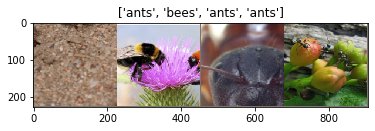

In [6]:
inputs, classes = next(iter(dataloaders['train']))
out = make_grid(inputs)
class_names = image_datasets['train'].classes
imshow(out, title=[class_names[x] for x in classes])


d) Implement a conditional generative model. Use at least one convolutional layer in your generative model and define a loss function that makes sense for this problem. 


In [7]:
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 112 x 112
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 56 x 56
        self.bn2 = nn.BatchNorm2d(128)
        self.fc_mu = nn.Linear(in_features=c*2*56*56, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*56*56, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        # notice, here we use use x for mu and for variance! 
        x_mu = self.fc_mu(x) 
        x_logvar = self.fc_logvar(x) #we don't calculate this from x_mu but from x!! This is crutial. 
        return x_mu, x_logvar

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*56*56)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 56, 56) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x   

In [10]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        # remember our encoder output consists of x_mu and x_logvar
        latent_mu, latent_logvar = self.encoder(x)
        # we sample from the distributions defined by mu and logvar
        # (function latent_sample defined below)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_() #define normal distribution
            return eps.mul(std).add_(mu) #sample from normal distribution
        else:
            return mu

In [11]:
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 50176), x.view(-1, 50176), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence


e) Train the network on cuda (I recommend to be clever and use a technique such as mini batches to train effectively, optional though). Show how the loss of the model evolves during training. 

f) Generate 4 images of each class after a number of epochs so we can see the generation quality improving during training.





In [12]:
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 3078791


In [13]:
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in dataloaders['train']:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...


RuntimeError: reduce failed to synchronize: device-side assert triggered

In [ ]:
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        # fetch the generated images by calling the model: 
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(dataloaders['val']).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

g) Does this model work well enough? What might be the reason for this? 

[your answer]